In [189]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score,roc_auc_score, plot_roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

#Aykırı değerler analizi:

In [90]:
def outlier_thresholds(dataframe, col_name, q1 = 0.05, q3 = 0.95):
  quantile1 = dataframe[col_name].quantile(q1)
  quantile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quantile3 - quantile1
  up_limit = quantile3 + 1.5 * interquantile_range
  low_limit = quantile1 - 1.5 * interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [91]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [92]:
df = pd.read_csv("diabetes.csv")

In [93]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [94]:
df.shape

(768, 9)

#Bağımlı ve bağımsız değişken analizi
#Target analizini yapalım.

In [95]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

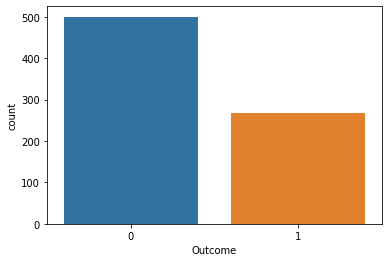

In [96]:
sns.countplot(x="Outcome", data=df)
plt.show()

In [97]:
#Bir ve sıfır sınıfının oranı:
df["Outcome"].value_counts()/ len(df) * 100

0   65.104
1   34.896
Name: Outcome, dtype: float64

#Bağımsız Değişkenlerin (Feature) Analizi

In [98]:
#Sadece sayısal değişkenleri getirip onların durumunu özetler.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


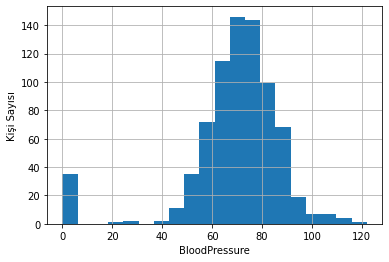

In [99]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.ylabel("Kişi Sayısı")
plt.show()

In [100]:
#Numerik sınıfların grafikleştirilmesi için bir fonksiyon tanımlayalım:
def plot_num_col(dataframe, num_col):
  dataframe[num_col].hist(bins=20)
  plt.xlabel("BloodPressure")
  plt.ylabel("Kişi Sayısı")
  plt.show(block=True) # Block = True çünkü peş peşe grafiklerin birbirini ezmesini istemiyoruz.


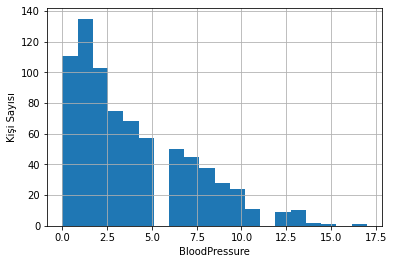

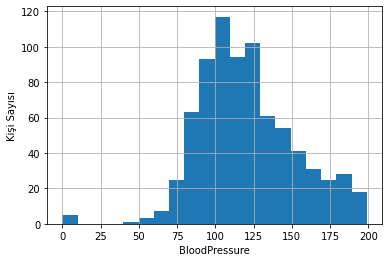

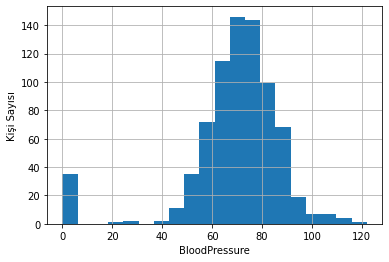

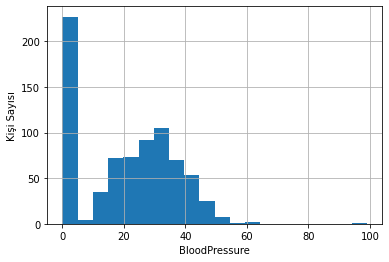

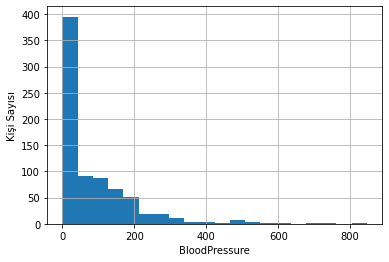

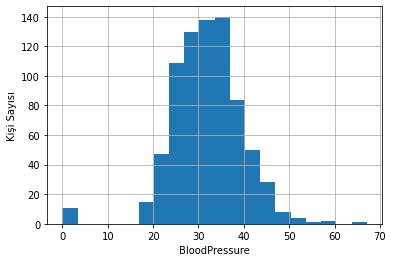

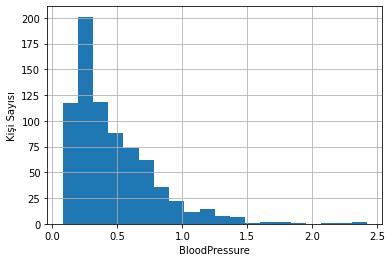

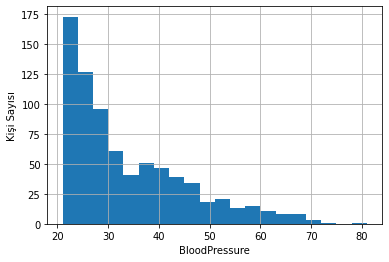

In [101]:
#Bütün değerler zaten sayısal olduğundan ayıklama yapmamıza gerek yok.
#Outcome yani bağımlı değişkenimizi dışarıda bıraktık.
cols = [col for col in df.columns if "Outcome" not in col]
for col in cols:
  plot_num_col(df, col)

#Target ve Features Değişkenlerini Beraber İnceleyelim

In [102]:
#Targete göre grupbya alıp sayısal değişkenlerin ortalamasını alırsak:
#Targetın bağımsız değişkenlere ne şekilde etki ettiğine yönelik bir fikir elde edilebilir.
df.groupby("Outcome").agg({"Pregnancies":"mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [103]:
#Bu işlem için de bir fonksiyon tanımlayalım:
def target_sum_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col:"mean"}), end="\n\n\n")

In [104]:
for col in cols:
  target_sum_with_num(df,"Outcome",col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [105]:
#Boş değerlerimiz var mı ?:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [106]:
# Yukarıda boş değerimiz yok gözüküyor ancak dataframein describe ına baktığımızda kan basıncı, insülin gibi değerlerin 0 olduğu görülebiliyor.
# Bu imkansızdır.
# Boş değerlere null yazmak yerine 0 atandığını anlarız.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [107]:
#Biz şimdilik eksik veri yokmuş gibi ilerleyeceğiz.
#Aykırı değer kontrolü yapalım:
for col in cols:
  print(col, check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [108]:
#Insülin değerimizde outlier değişkenler olduğu bilgisini aldık.
#Üst ve alt limitlere göre outlierları değiştirme işlemi yapalım:
replace_with_thresholds(df,"Insulin")
#Tekrardan outlierlarımız var mı diye kontrol sağlayalım:
for col in cols:
  print(col, check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


**Doğrusal ve uzaklık temelli yöntemlerde ve gradient Descent kullanılan yöntemlerde genellikle standartlaştırma işlemleri oldukça önem taşır. İki açıdan önemlidir.**
* 1- Modellerin değişkenlere eşit yaklaşması gerektiğini sağlamamız gerekmektedir. Örneğin değerleri daha büyük olanın değerleri daha küçük olanlara göre bir üstünlüğü olmadığını ifade etmemiz gerekir. Bu yüzden standartlaştırma işlemi yapılmalıdır.
* 2-Kullanılan parametre tahmin yöntemlerinin daha hızlı ve daha doğru tahminlerde bulunabilmesi için değişken standartlaştırma, scale etme, ölçeklendirme işlemlerini tercih ederiz.

In [109]:
#Robus Scaler işlemi bütün gözlem biriminin değerlerinden medyanı(çünkü medyan aykırı değerlere duyarsız) çıkarıp range(aralık) değerine bölüyor.
#Robus Scaler -> Aykırı değerlerden etkilenmiyor.
for col in cols:
  df[col] = RobustScaler().fit_transform(df[[col]])

In [110]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


#Modelleme & Prediction

In [111]:
y = df["Outcome"] # bağımlı değişken
X = df.drop(["Outcome"], axis =1) #cols, yani bağımsız değişken

In [114]:
log_model = LogisticRegression().fit(X,y)

In [117]:
log_model.intercept_ #bias yani b değerimiz 

array([-1.23439588])

In [119]:
log_model.coef_ # ağırlık yani w değişkenlerimiz

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [122]:
#b+ wi*xi
y_pred = log_model.predict(X)
y_pred[0:10] #tahmin edilen değerlerin ilk 10 tanesine bakalım

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [123]:
#Gerçek y değerlerinin 10 tanesine bakaalım
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

#Model Başarı Değerlendirme

In [128]:
def plot_confusion_matrix(y, y_pred):
  acc = round(accuracy_score(y,y_pred),2)
  cm = confusion_matrix(y, y_pred)
  sns.heatmap(cm,annot=True, fmt=".0f")
  plt.xlabel("y_pred")
  plt.ylabel("y")
  plt.title("Accuracy Score: {0}".format(acc), size=10)
  plt.show()

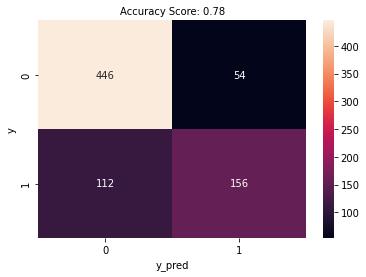

In [129]:
plot_confusion_matrix(y,y_pred)

In [133]:
#Sonuçları değerlendirelim:
print(classification_report(y,y_pred)) #support ilgili sınıfların frekanslarını ifade eder.

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



#Elde ettiğimiz sonuçlar:
#Accuracy : 0.78
#Presicion : 0.74
# Recall : 0.58
# F1-score : 0.65

#ROC AUC

In [137]:
y_prop = log_model.predict_proba(X)[:,1]
roc_auc_score(y,y_prop)

0.8393955223880598

ROC AUC = 0.8393955223880598

#Model Doğrulama : Holdout

In [156]:
#Veri setini iki parçaya böl birisiyle veriyi eğit, diğeriyle test et
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=17)

In [157]:
log_model = LogisticRegression().fit(X_train, y_train)

In [159]:
y_pred = log_model.predict(X_test) #Eğittiğimiz modeli elimizdeki test modeliyle test ediyoruz

In [160]:
y_pred #tahmin değerlerimiz

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [169]:
y_prob = log_model.predict_proba(X_test)[:,1]

In [170]:
print(classification_report(y_test, y_pred)) #tahmin ettiğimiz değerler ve gerçek değerlerin karşılaştırılması

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



#Önceki sonuçlar:
* Accuracy : 0.78
* Presicion : 0.74
* Recall : 0.58
* F1-score : 0.65

#Modeli train ettikten sonraki sonuçlar:
* Accuracy : 0.77  
* Presicion :  0.79 
* Recall : 0.53
* F1-score : 0.63

#ROC CURVE


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


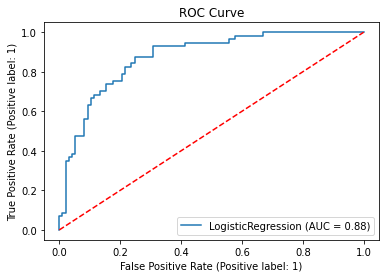

In [171]:
plot_roc_curve(log_model, X_test, y_test)
plt.title("ROC Curve")
plt.plot([0,1], [0,1], "r--")
plt.show()

In [173]:
#AUC
roc_auc_score(y_test, y_prob)

0.8755652016639537

#10 Katlı Çapraz Doğrulama

In [174]:
#Hangi train test yani hangi 80 e 20 sonucunda iyi modelleme yapılıyor?
#Bunun cevabını tam olarak bilemediğimizden 10 katlı çapraz doğrulama kullanılır.
y = df["Outcome"] 
X = df.drop(["Outcome"], axis =1)

In [175]:
# Veri seti bol ise holdout şeklinde yani train ve test olarak ikiye ayırabilir ve train setine 10 katlı validasyon uygulayabilir.
# Veri setiniz bol değilse bütün veriyi kullanarak da bu işlemi gerçekleştirebiliriz. Şuan yapaccağımız gibi:
log_model = LogisticRegression().fit(X,y)

In [179]:
cv_result = cross_validate(log_model,
                           X,y,
                           cv=5,
                           scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [180]:
cv_result["test_accuracy"].mean() #5 scorun ortalamasını aldık. Başarı metriğimiz:

0.7721925133689839

In [181]:
cv_result["test_precision"].mean()

0.7192472060223519

In [182]:
cv_result["test_recall"].mean()

0.5747030048916841

In [183]:
cv_result["test_f1"].mean()

0.6371421090986309

In [184]:
cv_result["test_roc_auc"].mean()

0.8327295597484277

#Bütün veriyle yaptığımız ve modelin görmediği verideki performansı bilmiyoruz diyerek model doğrulama yöntemlerine geldiğimiz kısım:
* Accuracy : 0.78
* Presicion : 0.74
* Recall : 0.58
* F1-score : 0.65

#Model doğrulama yöntemlerine gelip holdout yöntemini kullandığımız kısım:
* Accuracy : 0.77  
* Presicion :  0.79 
* Recall : 0.53
* F1-score : 0.63

#10 katlı çapraz sorgulama sonuçları:
* Accuracy : 0.7721925133689839 
* Presicion :  0.7192472060223519
* Recall : 0.5747030048916841
* F1-score : 0.6371421090986309
* ROC_AUC : 0.8327295597484277

* Accuracy -> %77 doğru sınıflandırıyoruz.
* Presicion -> %71 daha başarılı
* Recall -> %57  gerçekte 1 olan sınıfları tahmin etme başarımız
* F1 -> %63 büyük bir değişim olmamış
* ROC AUC -> bu modelin başarısı nedir sorusunun cevabı olarak %83 başarılı denilebilir.

#Prediction for A New Observation

In [185]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [187]:
random_user = X.sample(1, random_state=45) # rastgele bir kullanıcı aldık.

In [188]:
#Bu kullanıcının diyabet olup olmama tahminini gerçekleştiricez.
log_model.predict(random_user)

array([1])